# <font color=#B2D732> <span style="background-color: #4424D6"> Brain & Spinal Cord fMRI preprocessings </font>
<hr style="border:1px solid black">  

*Project: SpineBrain_Aging*  
*Paper: in prep*  
**@ author:** 
> Caroline Landelle, caroline.landelle@mcgill.ca // landelle.caroline@gmail.com   
> June 2024 (last update: 21 August 2025)

**Description:** 
> This notebook provides code for preprocessing fMRI data of simultaneous brain and spinal cord acquisition (single FOV).
> The second line of the section "imports & configuration" of this notebook should be modify with the good path 


**Associated files:**
> - ../config/preprocessing/01_brsc_preprocess_func.json ; This file contains the directories and should be modified first
> - ../config/participants_brsc_aging.tsv ; this file contains the information about the participants and should be updated after each new acquisition
> - ../brsc_preprocess.py ; Nothing should be changed in this file
> - ../brsc_utils.py; Nothing should be changed in this file
> - You need to copy the version sct6.1 of the template that include spinal segmental levels and put the path in the config file "PAM50_sct_dir":".../template_sct6.1",
 

**Steps:**
> **I. Brain and spinal cord preprocessings**  
> I.1 Slice timing correction  
> I.2 Crop anat and func images brain and spinal cord  

> **II. Brain preprocessings**  
> II.1 Motion correction  
> II.2 Segmentation   
> II.3 Brain coregistration into T1w

> **III. Spinal cord preprocessings**  
> III.1 Motion correction  
> III.2 Segmentation   
> III.3 Labeling of the inter vertebral disk  
> III.4 Coregistration to PAM50 template  

<hr style="border:1px solid black">


## <font color=#B2D732> <span style="background-color: #4424D6">  Imports & configuration </font >

In [1]:
import sys, json, glob, os, shutil
code_dir="/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2025_brsc_aging_project/"
os.chdir(code_dir)
sys.path.append(code_dir + "/code/") # Change this line according to your directory

from brsc_preprocess import Preprocess_BrSc, Preprocess_Sc, Preprocess_Br
import brsc_utils as utils
#
%load_ext autoreload
%autoreload 2
%matplotlib inline
    
# Load config file ------------------------------------------------------------
# The config file should be first review and all path should be modified (lines: )
with open(code_dir + '/config/preprocessing/01_brsc_preprocess_func.json') as config_file: # the notebook should be in 'xx/notebook/' folder #config_proprio
    config = json.load(config_file) # load config file should be open first and the path inside modified
    
preprocess_BrSc=Preprocess_BrSc(config) # initialize the function
preprocess_Sc=Preprocess_Sc(config) # initialize the function
preprocess_Br=Preprocess_Br(config) # initialize the function

The config files should be manually modified first
All the raw data should be store in BIDS format
 


<hr style="border:1px solid black">    

## <font color=#B2D732> <span style="background-color: #4424D6"> I Brain and spinal cord preprocessings </font>
### I.1 Slice timing correction   
Slice timing correction is applied in order to minimize the effect of slice ordering in the acquisition of the images.   
if you acquired the same file twice add info about the file to select ex: tag="run-02"



In [2]:
stc_files=[] # will contain the output filename for all participants.

for ID in config["participants_IDs"]:
    print(ID)
    func_tag = config['files_specificities']["func"].get(ID, "")+ "*_bold" # if you provided filename specifity it will be take into account   
    stc_files.append(preprocess_BrSc.stc(ID=ID,ses_name=config["design_exp"]["ses_names"][0],t_custom=True, redo=False,tag=func_tag)) 

A006_test
/cerebro/cerebro1/dataset//stratals/rawdata/sub-A006_test//func/sub-****_bold*.nii*
>>>>> slice timing correction was already completed for sub-A006_test


### I.2 Crop anat and func images brain and spinal cord
We separate brain and spinal cord because the next steps use differents apparoaches in each regionfolder.   
For now we are using a manual selection of the slices to crop (saved in a .tsv file)

In [3]:
tsv_f=code_dir + '/config/'+config["design_exp"]["info_participants"]# the tsv files with info about each participants
func_stc_cropped=[];anat_files=[];func_stc_brain_tmean=[];func_stc_sc_tmean=[];anat_stc_cropped=[];
tag_anat="";

for ID_nb in range(0,len(config["participants_IDs"])):
    preprocess_dir=config["main_dir"]+ config["preprocess_dir"]["bmpd_dir"] if ID[0]=="P" else config["main_dir"] +config["preprocess_dir"]["main_dir"]
    
    ID=config["participants_IDs"][ID_nb];IDbis=ID
    # crop func image:
    func_stc_cropped.append(preprocess_BrSc.crop_img(ID=ID,i_img=stc_files[ID_nb],tsv_f=tsv_f,img_type="func",redo=False,verbose=True)) # crop the func images
    func_stc_brain_tmean.append(utils.tmean_img(ID=ID,i_img=func_stc_cropped[ID_nb][0],verbose=True)) # calculate the brain mean image
    func_stc_sc_tmean.append(utils.tmean_img(ID=ID,i_img=func_stc_cropped[ID_nb][1],verbose=True)) # calculate the spinalcord mean image
    
    # crop anat image:
    if ID in config['files_specificities']["T1w"]:
        tag_anat=config['files_specificities']["T1w"][ID] # if you provided filename specifity it will be take into account 

    if ID in config["double_IDs"]:
        IDbis=config["double_IDs"][ID]

    raw_dir= config["main_dir"]+ config["bmpd_raw_dir"] if ID[0]=="P" else config["main_dir"] +config["raw_dir"]
    anat_files.append(glob.glob(raw_dir + "/sub-" + ID+ "/"+ config["design_exp"]["ses_names"][0]+ "/anat/sub-"+IDbis+tag_anat+"_T1w.nii*")[0])
    
    o_folder=preprocess_dir+  "/sub-" + ID+ "/"+config["design_exp"]["ses_names"][0] + "/anat/"
    anat_stc_cropped.append(preprocess_BrSc.crop_img(ID=ID,
                                                     i_img=anat_files[ID_nb],
                                                     ses_name=config["design_exp"]["ses_names"][0],
                                                     o_folder=o_folder,
                                                     tsv_f=tsv_f,
                                                     img_type="anat",redo=False))

    tag_anat=""

Done : check the outputs files in fsleyes by copy and past:
fsleyes /cerebro/cerebro1/dataset/stratals/derivatives/preprocessing//sub-A006_test//func///1_STC/brain/sub-A006_test_task-rest_bold_stc_brain_tmean.nii.gz
Done : check the outputs files in fsleyes by copy and past:
fsleyes /cerebro/cerebro1/dataset/stratals/derivatives/preprocessing//sub-A006_test//func///1_STC/spinalcord/sub-A006_test_task-rest_bold_stc_sc_tmean.nii.gz


<hr style="border:1px solid black">    

## <font color=#B2D732> <span style="background-color: #4424D6">  II. Brain preprocessings </font>

### II.1 Motion correction

0
Mean FD for sub-A006_test: 0.066 mm


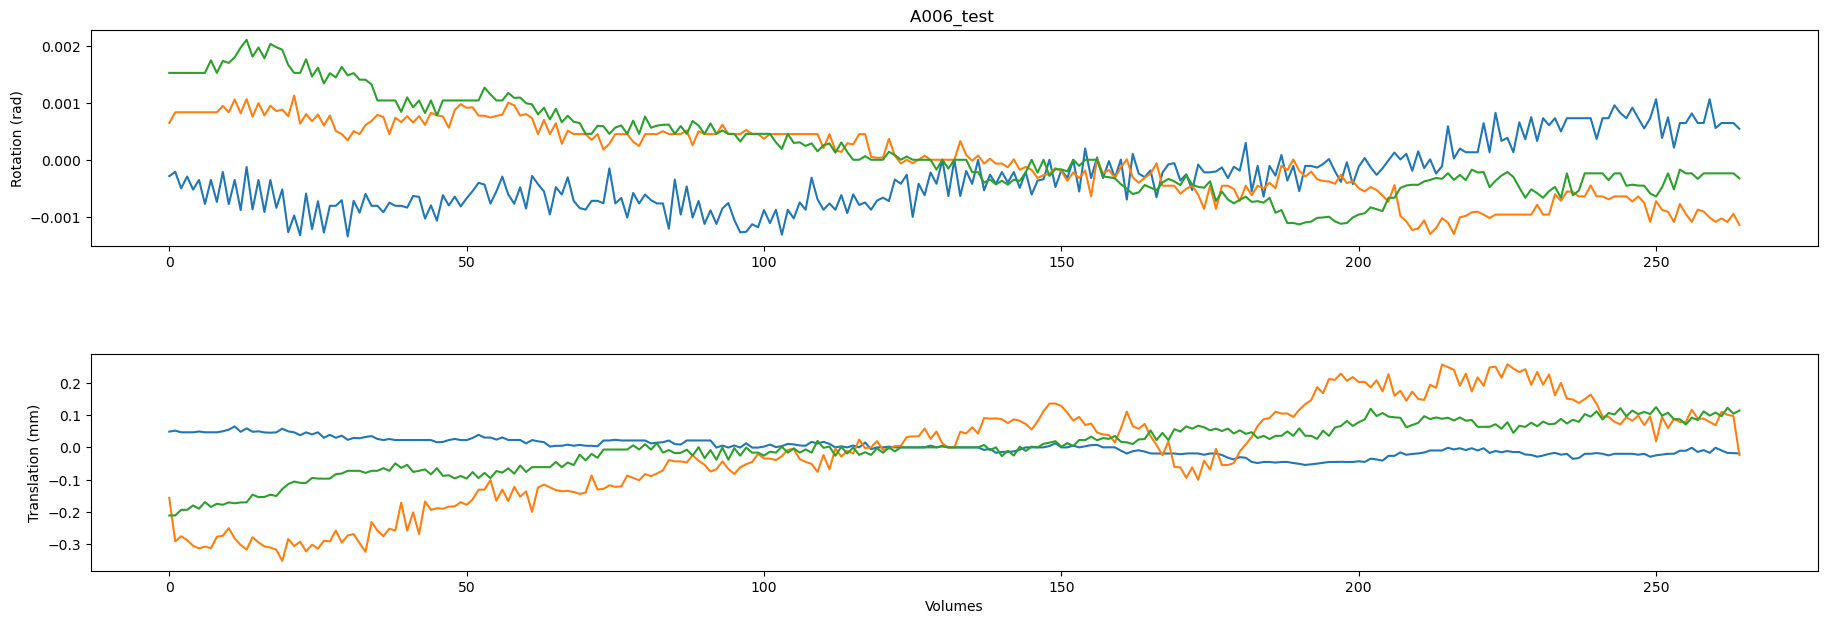

In [4]:
moco_brain_files=[] # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    print(ID_nb)
    ID=config["participants_IDs"][ID_nb]
    moco_brain_files.append(preprocess_Br.moco(ID=ID,
                                               i_img=func_stc_cropped[ID_nb][0],
                                               ses_name=config["design_exp"]["ses_names"][0],
                                               plot_show=True,redo=False))


### II.2 Segmentation and Normalization
This step provide tissue segmentation and warpping field to MNI space.

*This step requires matlab.engine it should be install correctly: CAT12 v12.9 on SPM12 / Matlab 2023b*

In [18]:
import matlab.engine
seg_brain_folder=[] # will contain the output filename for all participants.
for ID_nb, ID in enumerate(config["participants_IDs"]):
    seg_brain_folder.append(preprocess_Br.segmentation(ID=ID,i_img=anat_stc_cropped[ID_nb][0],ses_name=config["design_exp"]["ses_names"][0],redo=False))

    

Brain segmentation alredy exists for sub-A006_test here: /cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/sub-A006_test//anat//brain/segmentation/


### II.3 Func coregistration into T1w 

In [25]:
coreg_file=[]; coreg_csf_file=[]
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    # coregister mean image into T1w image
    coreg_file.append(preprocess_Br.coregistration_func2anat(ID=ID,
                                           func_img=moco_brain_files[ID_nb][1],
                                           anat_img=glob.glob(seg_brain_folder[ID_nb].split('mri')[0] + "*masked.nii.gz")[0],
                                          tag="_inT1w",redo=False,verbose=True))

    # coregister csf mask segmented from anatomical image into func space for later denoising.
    coreg_csf_file.append(preprocess_Br.coregistration_func2anat(ID=ID,
                                                             func_img=glob.glob(seg_brain_folder[ID_nb] + "/p3*_mask.nii")[0],
                                                             anat_img=moco_brain_files[ID_nb][1],
                                                             ses_name=config["design_exp"]["ses_names"][0],
                                                             tag="_infunc",redo=False,verbose=True))




Brain functional coregistration into anat space was already done, set redo=True to run again the coregistration
Brain functional coregistration into anat space was already done, set redo=True to run again the coregistration


In [26]:
coreg_csf_file

[('/cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/sub-A006_test//func///5_Coregistration/brain/aging_project/p3sub-A006_test_T1w_brain_mask_infunc.nii',)]

### II.4 Anat or Functional normalization in MNI space
In this study we generate a Dartel template for the group (See Notebook: 01b_brsc_**).  
The Func normalization will be done after generating this template and after denoising step 
The anat normalization can be done below if the dartel template already exists

In [ ]:
for ID_nb, ID in enumerate(config["participants_IDs"]):
    preproc_dir=config["main_dir"] + config["preprocess_dir"]["bmpd_dir"] if ID[0]=="P" else config["main_dir"]+config["preprocess_dir"]["main_dir"]                         
    indiv_dir=preproc_dir +"sub-"+ID+"/anat/"
    i_file=glob.glob(seg_brain_folder[ID_nb].split('mri')[0] + "*masked_SPM.nii")[0]                                               
    _=preprocess_Br.dartel_norm(ID=ID,
                                dartel_template=glob.glob(config["dartel_dir"].format(config["dartet_tag"]))[0],
                                warp_file=glob.glob(indiv_dir + config["preprocess_dir"]["T1w_brain_seg"] + "/mri/u_rp*" + config["dartet_tag"] + ".nii")[0],
                                i_file=i_file,
                                o_file=i_file.split('SPM')[0] + "inDartel.nii",
                                resolution=[1.5,1.5,1.5],
                                #brain_mask=config["tools_dir"]["main_codes"] + "/template/"+ config["MNI_mask"],
                                redo=False)

<hr style="border:1px solid black">

## <font color=#B2D732> <span style="background-color: #4424D6"> III. Spinal cord preprocessings </font>
### III.1 Motion correction 
#### a. Create the centerline and surrounding mask 
> - the centerline of the spinal cord was automatically extracted from the mean image or can be draw manually when it is necessary (manual=True), for manual step you should <span style="background-color: #FFFACD"> start at the very first slice </span> , otherwise the mask and the mean func image size will differ
> - A cylindrical mask with a diameter of 15 mm is drawn along this centerline and further used to exclude regions outside the spinal cord from the motion correction procedure, as those regions may move independently from the cord.   

<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  Manual step is required  </span> 

In [7]:
mocomask_sc_files=[] # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    mocomask_sc_files.append(preprocess_Sc.moco_mask(ID=ID,i_img=func_stc_sc_tmean[ID_nb],ses_name=config["design_exp"]["ses_names"][0],
                                                     manual=False,
                                                     redo_ctrl=False,redo_mask=False))

#### b. Calculate moco </font > 

/cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/sub-A006_test//func///3_MOCO//spinalcord/sub-A006_test_task-rest_bold_stc_sc_moco.nii.gz


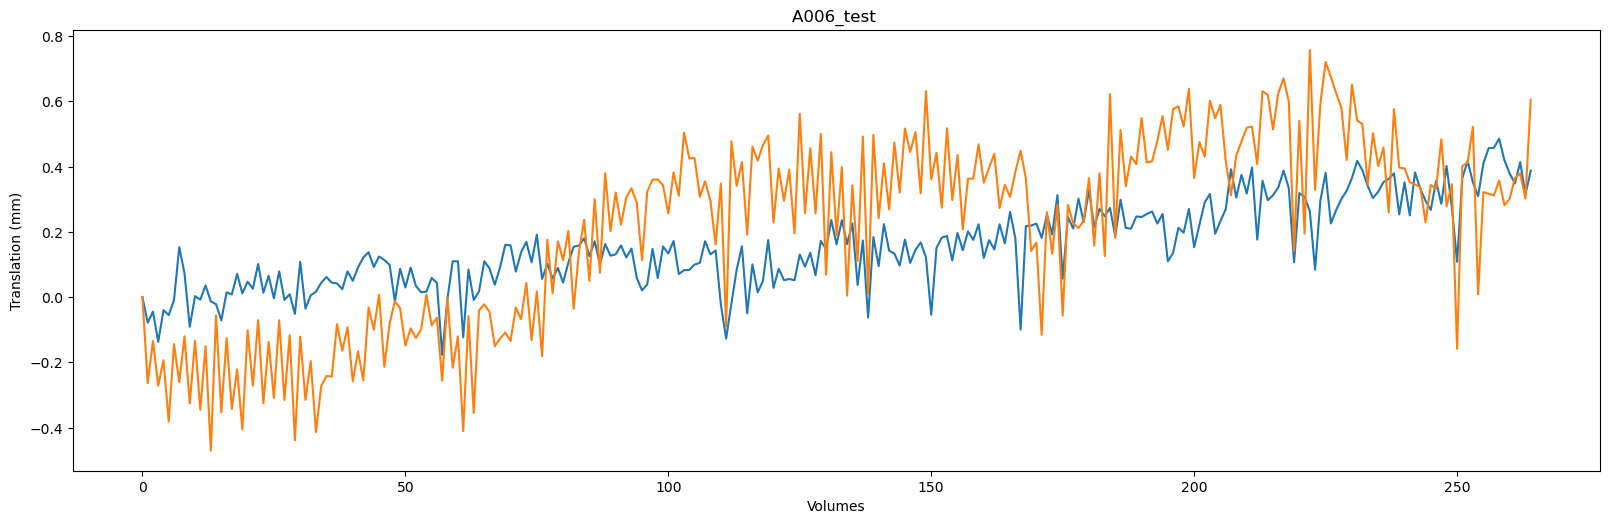

Framewise displacement, sub-A006_test
Diff_X: 0.071 mm
Diff_Y: 0.163 mm


In [8]:

moco_sc_files=[] # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    # clean you remporary folder between each individuals if necessary:
    string='find /tmp /var/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;' ; os.system(string)
    string='find /tmp /var/tmp /export02/data/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;'; os.system(string)

    moco_sc_files.append(preprocess_Sc.moco(ID=ID,i_img=func_stc_cropped[ID_nb][1],mask_img=mocomask_sc_files[ID_nb][0],
                                            ses_name=config["design_exp"]["ses_names"][0],
                                            plot_show=True,redo=False))


### III.2 Segmentation
#### a segment the spinal cord (WM+GM)
<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  In this dataset the segmentation mask were all corrected manually by overwriting the file: **/func///4_Segmentation//spinalcord/*seg.nii.gz  </span> 

In [9]:
seg_anat_sc_files=[];seg_func_sc_files=[]; # will contain the output filename for all participants.
for ID_nb, ID in enumerate(config["participants_IDs"]):
    seg_anat_sc_files.append(preprocess_Sc.segmentation(ID=ID,i_img=anat_stc_cropped[ID_nb][1], ses_name=config["design_exp"]["ses_names"][0],img_type="T1w",redo=False,verbose=True))
    seg_func_sc_files.append(preprocess_Sc.segmentation(ID=ID,i_img=moco_sc_files[ID_nb][1], ses_name=config["design_exp"]["ses_names"][0],
                                                        ctr_img=mocomask_sc_files[ID_nb][1] ,img_type="func",redo=False,verbose=True))

    # Apply dilation on func segmentation mask for futher data extraction in the csf
    dilated_mask=seg_func_sc_files[ID_nb].split('.')[0] + "_dilated.nii.gz"
    if not os.path.exists(dilated_mask):
        string=f"fslmaths {seg_func_sc_files[ID_nb]} -dilM -dilM -dilM -dilM -bin {dilated_mask}"
        os.system(string)

/cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/sub-A006_test//anat//T1w_seg_aging_project/
>>>>> Segmentation file already exists for the T1wimage of the sub-A006_test 
fsleyes /cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/sub-A006_test//anat//T1w_seg_aging_project/sub-A006_test_T1w_sc_seg.nii.gz
 
/cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/sub-A006_test//func///4_Segmentation/spinalcord/cord/
>>>>> Segmentation file already exists for the funcimage of the sub-A006_test 
fsleyes /cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/sub-A006_test//func///4_Segmentation/spinalcord/cord/sub-A006_test_task-rest_bold_stc_sc_moco_mean_seg.nii.gz
 


### III.3 Labeling of the inter vertebral disk
> This manual step should open a windows.  
> Place labels at the posterior tip of each inter-vertebral disc starting from 1  
*if the function is not working on the server copy and pass the command in the terminal directly*  
exemple here (right, in green): https://spinalcordtoolbox.com/user_section/tutorials/vertebral-labeling/labeling-conventions.html

In [10]:
vert_labels_files=[]; # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    vert_labels_files.append(preprocess_Sc.label_vertebrae(ID=ID,i_img=anat_stc_cropped[ID_nb][1],run_local="mnt/bagot/",
                                                           ses_name=config["design_exp"]["ses_names"][0],redo=False,verbose=True))

/cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/manual//sub-A006_test//anat/*_space-orig_label-ivd_mask.nii.gz
>>>>> Check if label file already exists for sub-A006_test
 


### III.4 Coregistration to PAM50 template
#### a Coregistration between anat image and PAM50
see details here: https://spinalcordtoolbox.com/user_section/tutorials/registration-to-template/template-registration.html

In [11]:
warpT1w_PAM50_files=[]; # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    warpT1w_PAM50_files.append(preprocess_Sc.coreg_anat2PAM50(ID=ID,i_img=anat_stc_cropped[ID_nb][1],seg_img=seg_anat_sc_files[ID_nb],
                                                          labels_img=vert_labels_files[ID_nb],
                                                              ses_name=config["design_exp"]["ses_names"][0],
                                                              img_type="t1",tag='T1w',
                                                          redo=False,verbose=True))

>>>>> Registration file anat2template already exists for sub-A006_test
 


#### b Coregistration between func image and PAM50

In [12]:
%%capture
func2PAM50_dir=[]; # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    func2PAM50_dir.append(preprocess_Sc.coreg_img2PAM50(ID=ID,i_img=moco_sc_files[ID_nb][1],i_seg=seg_func_sc_files[ID_nb],
                                                         mask_img=mocomask_sc_files[ID_nb][0],#coreg_type="centermass",
                                                         ses_name=config["design_exp"]["ses_names"][0],
                                                          initwarp=warpT1w_PAM50_files[ID_nb][1],initwarpinv=warpT1w_PAM50_files[ID_nb][0],
                                                          redo=False,verbose=True))

    #wrap PAM50 files into T2w space, this step requiered the v6.1 of the template to include the segmental levels (config["PAM50_sct_dir"])
    if not os.path.exists(func2PAM50_dir[ID_nb][0] + "/template/PAM50_cord.nii.gz"):
        string="sct_warp_template -d "+moco_sc_files[ID_nb][1]+" -w " + func2PAM50_dir[ID_nb][2] + " -a 0 -ofolder "+func2PAM50_dir[ID_nb][0]+" -t " +config["PAM50_sct_dir"]
        os.system(string)

        # add home made atlas (spinal levels from icaps)
        function="/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/spinalcordtoolbox-5.6.0/bin/isct_antsApplyTransforms"
        string=function + " -d 3 -i " +config["PAM50_sct_dir"] + "/template/PAM50_iCAPs_28Parcels_7Networks.nii.gz -o " +func2PAM50_dir[ID_nb][0] +"/template/PAM50_iCAPs_28Parcels_7Networks.nii.gz -t " + func2PAM50_dir[ID_nb][2] +" -r " +moco_sc_files[ID_nb][1] + " -n NearestNeighbor"
        os.system(string)
        string=function + " -d 3 -i " +config["PAM50_sct_dir"] + "/template/PAM50_Frostellv2_28Parcels_7Networks.nii.gz -o " +func2PAM50_dir[ID_nb][0] +"/template/PAM50_Frostell_28Parcels_7Networks.nii.gz -t " + func2PAM50_dir[ID_nb][2] +" -r " +moco_sc_files[ID_nb][1] + " -n NearestNeighbor"
        os.system(string)

#### c Coregistration csf segmentation in func space
This step is necessary to apply denoising in native space.   
<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  Check the spinal cord csf output and correct it manually,  </span> 


In [13]:
sc_CSFinFunc_files=[];  # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    # >>>>>>> Spinal cord <<<<<<<<<
    # Select files
    sc_csf_file=config["tools_dir"]["main_codes"] + '/template/' + config["PAM50_csf"]
    sc_warp_file=glob.glob(func2PAM50_dir[ID_nb][2])[0]
    # Run transformation
    sc_CSFinFunc_files.append(preprocess_Sc.apply_warp(ID=ID,i_img=sc_csf_file,
                                                       dest_img=moco_sc_files[ID_nb][1],
                                                       ses_name=config["design_exp"]["ses_names"][0],
                                                       warping_field=sc_warp_file,tag='_inFunc',
                                                       threshold=0.3,redo=False,verbose=True))
    

Tranformation was already applied put redo=True to redo that step
